In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install tensorflow_text

In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [4]:
df = pd.read_csv('/content/drive/MyDrive/spam.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
df["spam"] = df["Category"].apply(lambda x: 1 if x=="spam" else 0)


In [6]:
df.spam.value_counts()

0    4825
1     747
Name: spam, dtype: int64

<Axes: >

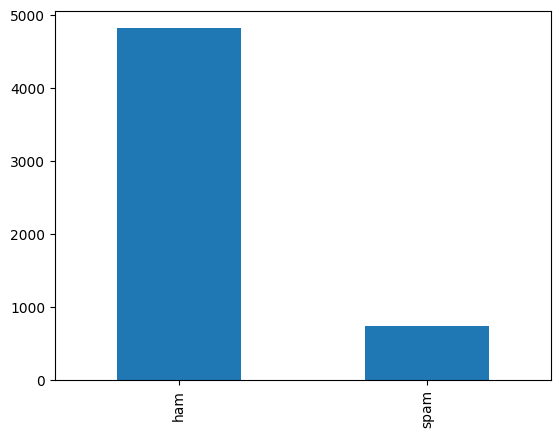

In [7]:
df.Category.value_counts().plot(kind='bar')


Logistic Regression Approach

In [8]:
df_a = df[:2000].copy()
df_a

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
1995,ham,Have you been practising your curtsey?,0
1996,ham,Shall i come to get pickle,0
1997,ham,Lol boo I was hoping for a laugh,0
1998,ham,"YEH I AM DEF UP4 SOMETHING SAT,JUST GOT PAYED2...",0


In [9]:
X=df_a['Message']
y=df_a['spam']

In [10]:
vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [11]:
X = tfidf_vectorizer.fit_transform(df_a['Message'])
y=df_a['spam']

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)


In [14]:
v = CountVectorizer()

In [15]:
text_clf = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf', LinearSVC()),
])


In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)


In [17]:
accuracy_score(y_val, y_pred)


0.9075

<Axes: >

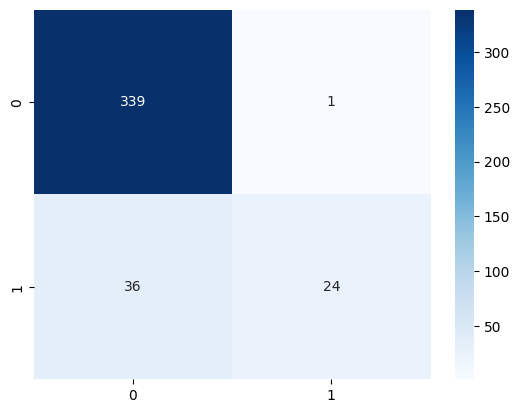

In [18]:
cfm = confusion_matrix(y_val, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

# Naive bayes

In [19]:
X=df_a['Message']
y=df_a['spam']
X = list(X)
y = list(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

In [22]:
from sklearn.pipeline import Pipeline
clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [23]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

In [24]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9875

<Axes: >

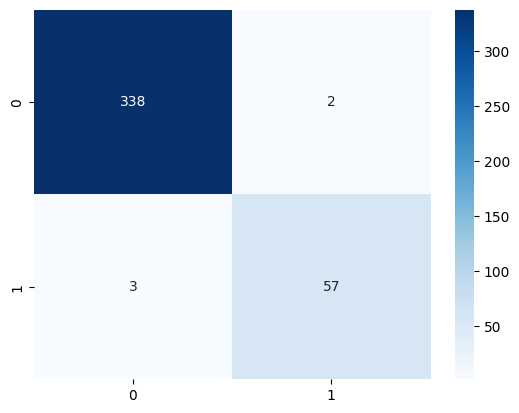

In [25]:

cfm = confusion_matrix(y_test, y_pred)


sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

In [26]:
clf.score(X_test,y_test)


0.9875

# BERT

In [27]:
# balancing the dataset 

df_spam = df[df['Category']=='spam']
df_ham = df[df['Category']=='ham']

df_hams = df_ham.sample(df_spam.shape[0])


df_balanced = pd.concat([df_hams, df_spam])
df_balanced.shape

(1494, 3)

In [28]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)


In [29]:

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [31]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3") ## downloading the BERT preprocesser
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [32]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [33]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)


l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [34]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [35]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [36]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
35/35 [==============================] - 33s 344ms/step - loss: 0.6297 - accuracy: 0.6482 - precision: 0.6436 - recall: 0.6643
Epoch 2/10
35/35 [==============================] - 12s 355ms/step - loss: 0.5076 - accuracy: 0.8196 - precision: 0.8196 - recall: 0.8196
Epoch 3/10
35/35 [==============================] - 14s 405ms/step - loss: 0.4410 - accuracy: 0.8554 - precision: 0.8491 - recall: 0.8643
Epoch 4/10
35/35 [==============================] - 13s 369ms/step - loss: 0.3941 - accuracy: 0.8813 - precision: 0.8662 - recall: 0.9018
Epoch 5/10
35/35 [==============================] - 12s 344ms/step - loss: 0.3686 - accuracy: 0.8795 - precision: 0.8670 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 14s 391ms/step - loss: 0.3337 - accuracy: 0.8946 - precision: 0.8797 - recall: 0.9143
Epoch 7/10
35/35 [==============================] - 15s 429ms/step - loss: 0.3165 - accuracy: 0.9062 - precision: 0.9012 - recall: 0.9125
Epoch 8/10
35/35 [================

In [37]:
model.evaluate(X_test, y_test)


12/12 [==============================] - 5s 326ms/step - loss: 0.2711 - accuracy: 0.9037 - precision: 0.9314 - recall: 0.8717


[0.2711423337459564, 0.903743326663971, 0.9314285516738892, 0.8716577291488647]

In [38]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 5s 358ms/step


In [40]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,

In [41]:
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[175,  12],
       [ 24, 163]])

Text(50.722222222222214, 0.5, 'Truth')

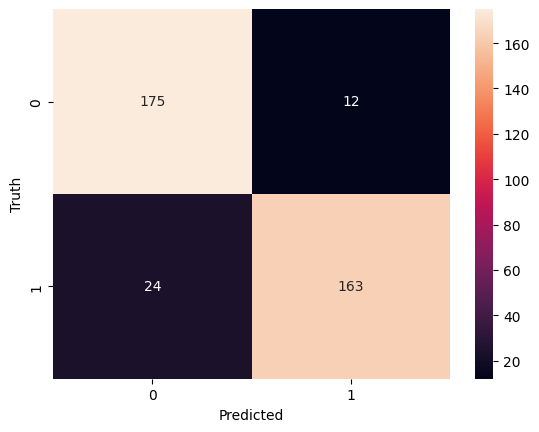

In [42]:

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [43]:
reviews = [
    "Just won a car! call us. this is important! Our number is 89203 ", # when you add a number, the prediction rate goes to spam
     "Just won a car! call us. this is important!",
    'call us at 80488. Your 500 free text messages go until December 2005.',
    'We are calling you about your cars extended warranty. Please call us back.',
    "Mom, what's for dinner tonight? I'm hungry.",
    "Omg! I just saw the fattest squirrel of my life! Call me!"]

model.predict(reviews)

1/1 [==============================] - 1s 821ms/step


array([[0.53314763],
       [0.1811948 ],
       [0.85616565],
       [0.46895087],
       [0.0436051 ],
       [0.10696336]], dtype=float32)